# Example of running a pushover using opseestools
#### Author: Orlando Arroyo
#### email: odarroyo@uc.cl

## Loading libraries, including the analysis module of opseestools

In [1]:
from openseespy.opensees import *
import opsvis as opsv 
import matplotlib.pyplot as plt 
import opseestools.analisis as an 
import numpy as np 

## Model definition

#### Define your OpenSeesPy model as you usually do, for example:

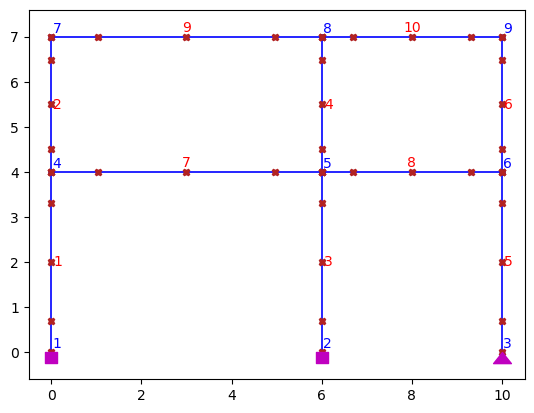

In [2]:
wipe() # es una buena práctica comenzar con un wipe 
model('basic','-ndm',2,'-ndf',3)
x1 = 6.0
x2 = 10.0
y1 = 4.0
y2 = 7.0

# nodes
node(1,0.0,0.0)
node(2,x1,0.0)
node(3,x2,0.0)
node(4,0.0,y1)
node(5,x1,y1)
node(6,x2,y1)
node(7,0.0,y2)
node(8,x1,y2)
node(9,x2,y2)

# supports
empotrado = [1,1,1]
grado2 = [1,1,0] 

fix(1,*empotrado)
fix(2,*empotrado)
fix(3,*grado2)

# diafragmas
equalDOF(4,5,1) # hace que el desplazamiento del nodo 5 en X sea igual que el del nodo 4
equalDOF(4,6,1)
equalDOF(7,8,1) 
equalDOF(7,9,1)

# masas
mass(4,1,1,0) # asignación de masas en X y Y al nodo 4
mass(5,1,1,0)
mass(6,1,1,0)
mass(7,1,1,0)
mass(8,1,1,0)
mass(9,1,1,0)

# Para el concreto no confinado
E = 24000000.0 # 24GPa pasados a KPa para hacerlo consistente
fc = 28000.0
ec = 2*fc/E
fcu = 0.2*fc
ecu = 0.006

# Para el concreto confinado
k=1.3
fcc=28000.0*k
ecc= 2*fcc/E
fucc=0.2*fcc
eucc=0.02

# Para el acero
Fy=420000.0
Es=210000000.0

uniaxialMaterial('Concrete01', 2, fc, ec, fcu, ecu)
uniaxialMaterial('Concrete01', 1, fcc, ecc, fucc, eucc)
uniaxialMaterial('Steel01', 3, Fy, Es, 0.01)

# Se presenta el ejemplo de la creación de una sección de fibras
# seccion de 30 x 30 cm con 8 # 4

Bcol = 0.3
Hcol = 0.3
c = 0.05  # recubrimiento 

# creación de la sección de fibra
y1col = Hcol/2.0
z1col = Bcol/2.0

y2col = 0.5*(Hcol-2*c)/3.0

nFibZ = 1
nFibZcore= 10
nFib = 20
nFibCover, nFibCore = 3, 16
As4 = 0.000127
As5 = 0.0002
As7 = 0.000387

sec30x30 = 1 # tag de la sección a crear

# Se empleará la librería de opsvis que permite visualizar la sección
s30x30 = [['section', 'Fiber', sec30x30, '-GJ', 1.0e6],
             ['patch', 'rect', 1, nFibCore, nFibZcore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 2, nFib, nFibZ, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 2, nFib, nFibZ, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 2, nFibCover, nFibZ, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 2, nFibCover, nFibZ, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 3, 3, As4, y1col-c, z1col-c, y1col-c, c-z1col],
             ['layer', 'straight', 3, 2, As4, y2col, z1col-c, y2col, c-z1col],
             ['layer', 'straight', 3, 2, As4, -y2col, z1col-c, -y2col, c-z1col],
             ['layer', 'straight', 3, 3, As4, c-y1col, z1col-c, c-y1col, c-z1col]]

# Los siguientes comandos dibujan la sección para saber que nos quedó bien
matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
#plt.figure()
#opsv.plot_fiber_section(s30x30, matcolor=matcolor)
#plt.axis('equal')

# El siguiente comando es el que propiamente crea la sección escribiendo el código definido en la lista
opsv.fib_sec_list_to_cmds(s30x30)

# Para generar los elementos de fibras deberá indicarse los puntos de integración y el esquema de integración
pint = 5 # puntos de integración
beamIntegration('Lobatto', sec30x30, sec30x30,pint) # esquema de integración

# Transformaciones del los elementos
lineal = 1
geomTransf('Linear',lineal) # transformación lineal

pdelta = 2
geomTransf('PDelta',pdelta) # transformación lineal

# Columnas
element('forceBeamColumn',1, 1,4 ,pdelta,sec30x30)
element('forceBeamColumn',2, 4,7 ,pdelta,sec30x30)
element('forceBeamColumn',3, 2,5 ,pdelta,sec30x30)
element('forceBeamColumn',4, 5,8 ,pdelta,sec30x30)
element('forceBeamColumn',5, 3,6 ,pdelta,sec30x30) 
element('forceBeamColumn',6, 6,9 ,pdelta,sec30x30) 

# Vigas
element('forceBeamColumn',7, 4,5 ,lineal,sec30x30)
element('forceBeamColumn',8, 5,6 ,lineal,sec30x30)
element('forceBeamColumn',9, 7,8 ,lineal,sec30x30) 
element('forceBeamColumn',10, 8,9 ,lineal,sec30x30) 

# para ver el modelo
opsv.plot_model()

timeSeries('Linear', 1)
pattern('Plain',1,1)
# El comando eleload asigna una carga al elemento:
vigas = [7,8,9,10] # tags de los elementos vigas
wviga = 20 # carga disitriibuida sobre la viga
eleLoad('-ele',*vigas,'-type','beamUniform',-wviga) # aplicación de la carga sobre la viga

## Running gravity analysis using opseestools

In [3]:
an.gravedad()
loadConst('-time',0.0)

## Running pushover analysis using opseestools

Text(0, 0.5, 'Base shear (kN)')

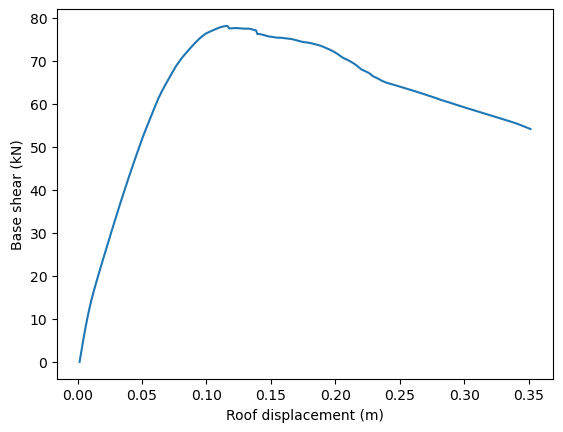

In [5]:
dtecho, Vbasal = an.pushover2(0.05*y2, 0.001, 9, 1)
plt.xlabel('Roof displacement (m)')
plt.ylabel('Base shear (kN)')

### For each function in opseestools, you can read its docstring using the Python help command and get information about its inputs and outputs

In [6]:
help(an.pushover2)

Help on function pushover2 in module opseestools.analisis:

pushover2(Dmax, Dincr, IDctrlNode, IDctrlDOF, norm=[-1, 1], Tol=1e-08)
    Function to calculate the pushover
    
    Parameters
    ----------
    Dmax : float
        Maximum displacement of the pushover.
    Dincr : float
        Increment in the displacement.
    IDctrlNode : int
        control node for the displacements.
    IDctrlDOF : int
        DOF for the displacement.
    norm : list, optional
        List that includes the roof displacement and the building weight to normalize the pushover and display the roof drift vs V/W plot. The default is [-1,1].
    Tol : float, optional
        Norm tolerance. The default is 1e-8.
    
    Returns
    -------
    techo : numpy array
        Numpy array with the roof displacement recorded during the Pushover.
    V : numpy array
        Numpy array with the base shear (when using an unitary patter) recorded during the Pushover. If pattern if not unitary it returns the multi